In [1]:
import numpy as np
from coverage import *
from datetime import datetime, timezone, timedelta
import dataclasses
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import branca
import folium

! mkdir tmp

mkdir: tmp: File exists


In [2]:
from landsat import Instrument, Platform, Scene

In [3]:
start_dt = datetime.fromisoformat(Scene.start_utc)
num_days = 2

tles = gen_sats(
    # sat_nos=[Platform.norad_id] # How to best handle multiple platforms? (TLE vs. SPG4 model too)
    # sat_nos=[39084]
    sat_nos=[39084,49260]
)

inst = camera_model(
    name=Instrument.name, 
    fl=Instrument.focal_length_mm, 
    pitch=Instrument.pitch_um*1e-3, 
    h_pix=Instrument.rows, 
    v_pix=Instrument.cols, 
)

times = gen_times(
    start_yr=start_dt.year,
    start_mo=start_dt.month, 
    start_day=start_dt.day, 
    days=num_days, 
    step_min=Instrument.img_period)

xcell_size = ycell_size = .1

Satellite(s) Loaded from TLE:

[<EarthSatellite LANDSAT 8 catalog #39084 epoch 2022-06-15 18:38:09 UTC>]

[<EarthSatellite LANDSAT 9 catalog #49260 epoch 2022-06-15 11:12:37 UTC>]

Propogation time: 
 2022-07-19 00:00:00+00:00 
to 
 2022-07-20 23:59:48+00:00

In [4]:
## Batch FOV generation over N satellites - TODO: build multiple sats into config/ main script
gdfs = []
for tle in tles:
    sat = tle[0]
    fov_df = forecast_fovs(sat, times, inst)
    gdfs.append(fov_df)
fov_df = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True), crs="epsg:4326")

## Filter shapes crossing anti-meridian - also in main function
## TODO: Switch to stactools solution for this
fov_df["lonspan"] = fov_df.bounds['maxx'] - fov_df.bounds['minx']
fov_df = fov_df[fov_df["lonspan"] < 20].copy()

## Create cmap for unique satellites and create color column
sat_ids = list(fov_df["id"].unique()).sort()
cmap = branca.colormap.StepColormap(['red', 'blue'], sat_ids, vmin=139084, vmax = 149260)
fov_df['color'] = fov_df['id'].apply(cmap)

## Save to geojson based on sat name
for satname in fov_df.satellite.unique():
    fov_df[fov_df.satellite==satname].to_file("./tmp/{}_fovs.geojson".format(satname.replace(" ", "_")))
fov_df

/Users/kevinlalli/miniconda3/envs/coverage/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/kevinlalli/miniconda3/envs/coverage/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


satellite      id                     time  \
0      LANDSAT 8  139084  2022-07-19 00:00:00 UTC   
1      LANDSAT 8  139084  2022-07-19 00:00:22 UTC   
2      LANDSAT 8  139084  2022-07-19 00:00:44 UTC   
3      LANDSAT 8  139084  2022-07-19 00:01:06 UTC   
4      LANDSAT 8  139084  2022-07-19 00:01:28 UTC   
...          ...     ...                      ...   
15705  LANDSAT 9  149260  2022-07-20 23:58:20 UTC   
15706  LANDSAT 9  149260  2022-07-20 23:58:42 UTC   
15707  LANDSAT 9  149260  2022-07-20 23:59:04 UTC   
15708  LANDSAT 9  149260  2022-07-20 23:59:26 UTC   
15709  LANDSAT 9  149260  2022-07-20 23:59:48 UTC   

                                                geometry   lonspan      color  
0      POLYGON ((-10.74489 -65.23485, -7.09859 -64.63...  4.944736  #ff0000ff  
1      POLYGON ((-11.76697 -63.97038, -8.26544 -63.38...  4.698954  #ff0000ff  
2      POLYGON ((-12.70956 -62.70021, -9.34225 -62.13...  4.476816  #ff0000ff  
3      POLYGON ((-13.58304 -61.42504, -10.34018 -60.8...  4.275413  #ff0000ff  
4      POLYGON ((-14.39607 -60.14545, -11.26870 -59.6...  4.092258  #ff0000ff  
...                                                  ...       ...        ...  
15705  POLYGON ((158.28108 25.04390, 156.53881 25.398...  2.129958  #0000ffff  
15706  POLYGON ((157.94957 23.71950, 156.22552 24.072...  2.106714  #0000ffff  
15707  POLYGON ((157.62335 22.39446, 155.91623 22.746...  2.085180  #0000ffff  
15708  POLYGON ((157.30200 21.06881, 155.61061 21.419...  2.065281  #0000ffff  
15709  POLYGON ((156.98517 19.74262, 155.30832 20.091...  2.046949  #0000ffff  

[15512 rows x 6 columns]

In [5]:
# %%timeit
get_inst_fov(sat, times[0], inst)

{'c1': {'lat': 63.088882683125675, 'lon': 171.46385838173472},
 'c2': {'lat': 63.654870362239215, 'lon': 168.05410014506015},
 'c3': {'lat': 62.04926130005797, 'lon': 166.89629124350247},
 'c4': {'lat': 61.51333843738, 'lon': 170.14891081178135}}

In [6]:
## Plotting FOVs

## Select AOI from gpd naturalearth dataset (filter by .name for country, .continent for continent)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[world.continent != "Antarctica"]
# world = world[world.continent != "Seven seas (open ocean)"]

## Drop any FOVs not over land area
join = fov_df.sjoin(world, how="left").dropna()
fov_df.loc[join.index, 'mode'] = "SCIENCE"
fov_df.loc[~fov_df.index.isin(join.index), 'mode'] = "STANDBY"

## Make a folium map
m = fov_df[fov_df['mode']=="SCIENCE"].explore(color="color", style_kwds={'fillOpacity':0.2}, tooltip=["satellite", "time"])

## Add WRS2
# wrs2 = gpd.read_file('./WRS2_descending_0/WRS2_descending.shp')
# wrs2 = wrs2.cx[xmin: xmax, ymin: ymax]
# folium.GeoJson(data=wrs2["geometry"], overlay=False).add_to(m)

## View or save
m#.save("./tmp/fovs_map.html")

In [7]:
fov_df.time = pd.to_datetime(fov_df.time)
fov_df["frac_days"] = fov_df.time.dt.dayofweek + fov_df.time.dt.hour/24 + fov_df.time.dt.minute/(24*60) + fov_df.time.dt.second/(24*60*60)
fov_df['time_gap'] = fov_df['frac_days'] - fov_df['frac_days'].shift(1)

In [8]:
## Coverage data analysis for single satellite/ batch of satellites

## Set AOI
# aoi =  world[world.name == "Brazil"].geometry
# aoi =  world[world.continent == "North America"].geometry
# aoi = world[world.name == "United States of America"].geometry # Includes Alaska...

## Or read in aoi from .geojson
aoi = gpd.read_file('./aois/eastern_us.geojson').geometry # ...so use AOI for subsection of US

## Filter fov_df by aoi
xmin, ymin, xmax, ymax= aoi.total_bounds
revisit_df = fov_df.cx[xmin: xmax, ymin: ymax]

## Create revisit map on regular grid
grid, grid_shape = calculate_revisits(revisit_df, aoi, grid_x=xcell_size, grid_y=ycell_size)
grid.to_file('./tmp/all_revisits.geojson')
grid.n_visits.fillna(0).describe()
m = revisit_map(grid, grid_shape, grid_x=xcell_size, grid_y=ycell_size)
m#.save("./tmp/revisits_map.html")

/Users/kevinlalli/miniconda3/envs/coverage/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


/Users/kevinlalli/miniconda3/envs/coverage/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<BarContainer object of 319 artists>

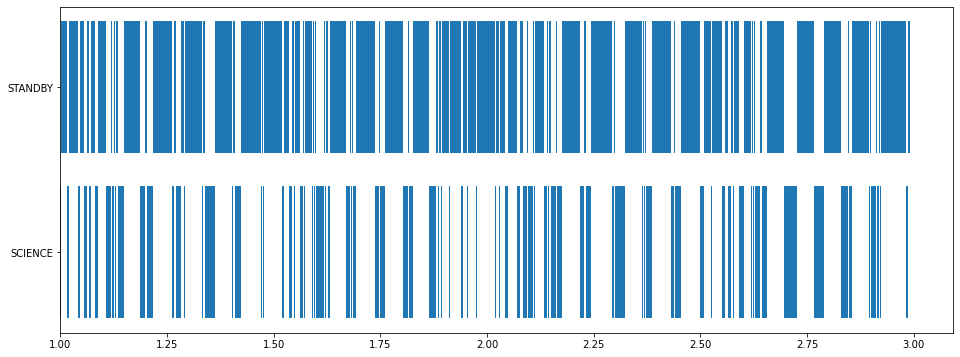

In [9]:
my_column_changes = fov_df["mode"].shift() != fov_df["mode"]

change = fov_df[my_column_changes]#[:100]

change['time_gap'] = change['frac_days'].shift(-1) - change['frac_days']
change = change[change['time_gap'] > 0]
change = change[change.satellite == "LANDSAT 9"]

fig, ax = plt.subplots(1, figsize=(16,6))
ax.barh(change['mode'], change.time_gap, left=change.frac_days) #, color=df.color)

<AxesSubplot:ylabel='Frequency'>

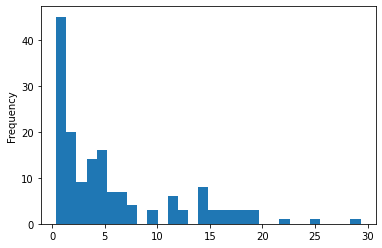

In [10]:
((change[change["mode"] == "SCIENCE"]).time_gap*24*60).plot.hist(bins=30)

In [11]:
change[change["mode"] == "SCIENCE"].time_gap.sum()/(change[change["mode"] == "STANDBY"].time_gap.sum() + change[change["mode"] == "SCIENCE"].time_gap.sum())

0.3225971370143134